In [1]:
import xarray as xr
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import HourLocator
import cmocean

In [2]:
root = "ipfs://QmfAzqPtR99owGURk27JV4Vgwun1CxRpKjomtkBxYufv5b"
dset_meteo = xr.open_dataset(f"{root}/DShip.zarr",engine="zarr")
dset_disdro = xr.open_dataset(
    f"{root}/disdrometer/DSD_METEOR_merged.zarr",engine="zarr")
dset_sea_snake = xr.open_dataset(f"{root}/SeaSnake/met_203_1_SeaSnake.zarr",engine="zarr")
dset_termo = xr.open_dataset(f"{root}/thermosalinograph/met_203_1_tsal.zarr",engine="zarr")
dset_lidart = xr.open_dataset(f"{root}/LICHT-LIDAR_t.zarr",engine="zarr")
dset_lidart_sel = dset_lidart.sel(time= slice('2024-09-08 06 ','2024-09-08 17:00:00'),alt=slice(0,600))

In [3]:
sea_pool_file = '/Users/hans/Documents/bow_tie/SEA-POOL/SEA-POL_gridded_rainrate_spatial_means_masked.nc'
dset_pool = xr.open_dataset(sea_pool_file,chunks='auto' )

In [4]:
sea_pool_qv_file = '/Users/hans/Documents/bow_tie/SEA-POOL/qvp_1D.nc'
dset_pool_qv = xr.open_dataset(sea_pool_qv_file,chunks='auto' )

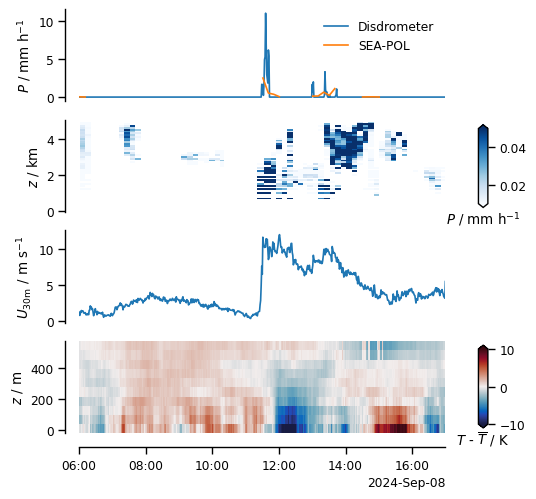

In [6]:
sns.set_context("paper")
fig = plt.figure(figsize=(12/2.54,14/2.54),facecolor='white')
ax1=fig.add_axes([0.97,0.52,0.02,0.15])

ax2=fig.add_axes([0.97,0.12,0.02,0.15])

ax= fig.add_subplot(411)
dset_disdro.rain_rate_qc.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00')).plot(label='Disdrometer')
dset_pool.rain1_int.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00')).plot(label='SEA-POL')

ax.set_xlabel(None)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
ax.set_xticks([])
ax.set_xticklabels({})
ax.set_ylabel(r'$P$ / mm h$^{-1}$')
sns.despine(offset=10,ax=ax)
ax.spines['bottom'].set_visible(False)
plt.legend(frameon=False)

ax= fig.add_subplot(412)
plot_seapool = dset_pool_qv.assign_coords({'Z':dset_pool_qv.Z.values/1000}).rainrate_int.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00'),Z=slice(0,5)).plot(
    x='time',vmin=0.01,vmax=0.05,cmap='Blues',add_colorbar=False)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
sns.despine(offset=10,ax=ax)
ax.set_xticks([])
ax.set_xticklabels({})
ax.spines['bottom'].set_visible(False)
ax.set_ylabel(r'$z$ / km')

ax= fig.add_subplot(413)
dset_meteo.wspd.sel(time=slice('2024-09-08 06','2024-09-08 17:00')).plot()
ax.set_xlabel(None)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
ax.set_xticks([])
ax.set_xticklabels({})
ax.set_ylabel(r'$U_\mathrm{30m}$ / m s$^{-1}$')
sns.despine(offset=10,ax=ax)
ax.spines['bottom'].set_visible(False)

ax= fig.add_subplot(414)
plot_cb = (dset_lidart_sel.ta -dset_lidart_sel.ta.mean('time')).plot(
    y='alt',
    cmap=cmocean.cm.balance,
    vmin=-10,vmax=10,
    add_colorbar=False)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
sns.despine(offset=10,ax=ax)
plt.subplots_adjust(hspace=0.2)
ax.xaxis.set_major_locator(HourLocator(byhour=range(0,24,2)))
ax.set_ylabel(r'$z$ / m')
ax.set_xlabel(None)

b1 = plt.colorbar(plot_seapool,
                  extend='both',
                  orientation='vertical',
                  cax=ax1,shrink=0.8,pad=0.09)
b1.ax.set_xlabel(r"$P$ / mm h$^{-1}$");

b2 = plt.colorbar(plot_cb,
                  extend='both',
                  orientation='vertical',
                  cax=ax2,shrink=0.8,pad=0.09)
b2.ax.set_xlabel(r"$T$ - $\overline{T}$ / K");
b2.ax.set_yticks([-10,0,10])

plt.savefig('../figures/precip_wind_temp_wind_gust.pdf',
            format='pdf',bbox_inches='tight',orientation={'landscape'})